# Fig. 5a

In [52]:
import pandas as pd
import PyComplexHeatmap as pch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [53]:
lfc_cutoff = 1
padj_cutoff = 0.01

## Read in muscle DEG results

In [201]:
tissue = 'Gastrocnemius'

df_genes = pd.read_csv(f'/share/crsp/lab/seyedam/share/igvf_pipeline/figures/degs_old_pbulk_strategy/{tissue}/results_de_analysis_celltypes_no_min_cells.csv')
ct_degs = df_genes[(df_genes['log2FoldChange'] >= lfc_cutoff) & (df_genes['padj'] <= padj_cutoff)]
ct_degs = ct_degs[['gene_name','subtype', 'tissue']].drop_duplicates()

geno_degs_unfilt = pd.read_csv('/share/crsp/lab/seyedam/share/igvf_pipeline/figures/specificity/sig_degs_all_tissues_b6j.csv', index_col = 0)
geno_degs = geno_degs_unfilt[geno_degs_unfilt['tissue'] == tissue]
geno_degs.rename(columns={'celltype': 'subtype'}, inplace=True)
mask = geno_degs['comparison'].str.contains('B6J_vs_')
geno_degs.loc[mask, 'log2FoldChange'] = -geno_degs.loc[mask, 'log2FoldChange']
geno_degs['direction'] = np.where(
geno_degs['log2FoldChange'] > 0,
    "Upregulated", 
    "Downregulated")


geno_degs = geno_degs[['gene_name', 'subtype', 'genotype', 'tissue','direction']].drop_duplicates()
merged_df  = pd.merge(geno_degs, ct_degs, on=['gene_name', 'subtype', 'tissue'])


/tmp/ipykernel_1911856/467429875.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geno_degs.rename(columns={'celltype': 'subtype'}, inplace=True)
/tmp/ipykernel_1911856/467429875.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geno_degs['direction'] = np.where(


In [202]:
# Group by genotype and subtype and count unique gene_names
gene_counts = merged_df.groupby(['genotype', 'subtype'])['gene_name'].nunique().unstack(fill_value=0)
gene_counts=gene_counts.transpose()
gene_counts['B6J'] = 0

In [203]:
df_row = merged_df[['tissue', 'subtype']].drop_duplicates()


In [112]:
sizes = pd.read_csv(f'/share/crsp/lab/seyedam/share/igvf_pipeline/IGVF_analysis/cellbender_tissues/obs_tables/{tissue}_annotated_metadata.csv')
cell_counts = sizes.groupby(['subtype', 'Tissue']).size().reset_index(name='num_cells')
total_cells_per_tissue = cell_counts.groupby('Tissue')['num_cells'].sum().reset_index(name='total_cells')
cell_counts = cell_counts.merge(total_cells_per_tissue, on='Tissue')
cell_counts['percent_cells'] = (cell_counts['num_cells'] / cell_counts['total_cells']) * 100


/tmp/ipykernel_1911856/3317122258.py:1: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  sizes = pd.read_csv(f'/share/crsp/lab/seyedam/share/igvf_pipeline/IGVF_analysis/cellbender_tissues/obs_tables/{tissue}_annotated_metadata.csv')


In [204]:
df_row = df_row.merge(cell_counts, on=['subtype'], how='left')
df_row = df_row.sort_values(by=['percent_cells'], ascending=False)
df_row.index = df_row['subtype']

In [205]:
geno_dict = {
    '129S1J': '#DA9CC1',  
    'AJ': '#F4C245',             
    'B6J': '#C0BFBF',               
    'CASTJ': '#55AF5B',  
    'NODJ': '#4F6EAF',        
    'NZOJ': '#52A5DB',              
    'PWKJ': '#D83026',        
    'WSBJ': '#683C91'   
}

strain_dict = {'Lab': 'darkgrey', 'Wild': '#d3a021'}


df_col = pd.DataFrame({
    "Genotype": gene_counts.columns,
    "Strain type": ["Wild" if x in ["CASTJ","PWKJ","WSBJ"] else "Lab" for x in gene_counts.columns]
})
df_col = df_col.drop_duplicates()

genotype_categories = ['AJ','B6J','129S1J','NODJ','NZOJ','CASTJ','PWKJ','WSBJ']
df_col['Genotype'] = pd.Categorical(df_col['Genotype'], categories=genotype_categories, ordered=True)
df_col.sort_values(['Genotype'], inplace=True)
df_col = df_col.set_index("Genotype", drop=False)

col_ha = pch.HeatmapAnnotation(Genotype=pch.anno_simple(df_col['Genotype'],colors=geno_dict),
                               Type=pch.anno_simple(df_col['Strain type'],colors=strain_dict),
                               verbose=1,
                               label_kws = {'visible': False},
                               axis=1)

## Plot

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 20.844444444444445 mm


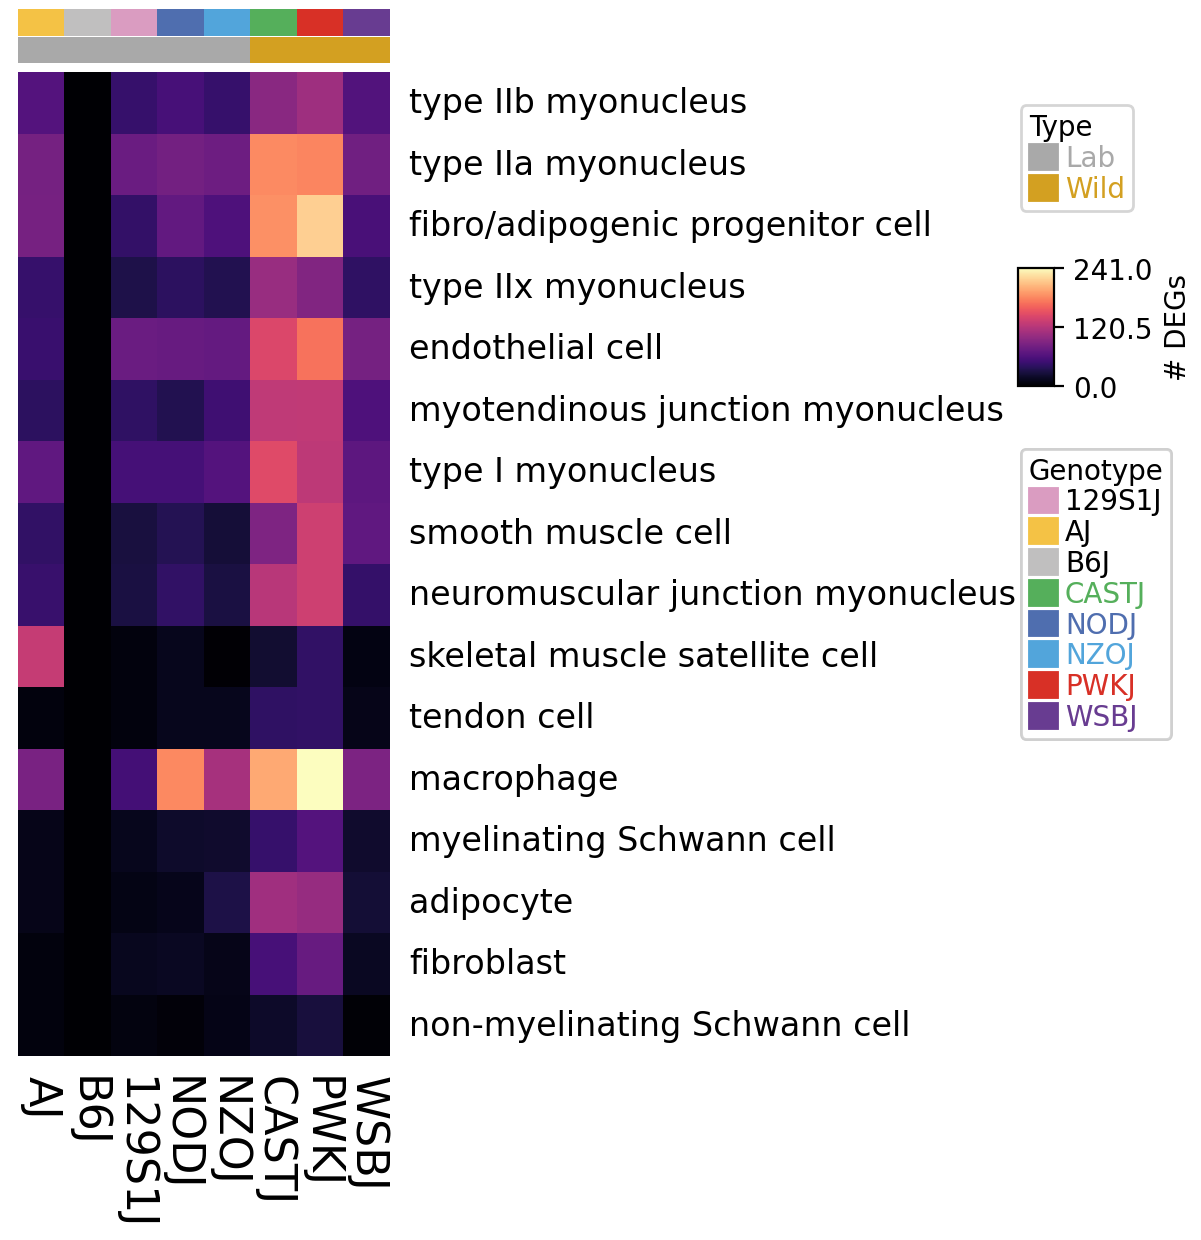

In [206]:
plt.figure(figsize=(2.5, 6), dpi = 200)

cm = pch.ClusterMapPlotter(data=gene_counts.loc[df_row['subtype'].unique().tolist(),df_col.index.tolist()],
                           show_rownames = True, 
                           show_colnames = True, 
                           cmap = "magma",
                           label = "# DEGs",
                           top_annotation=col_ha, 
                           row_cluster=False,
                           col_cluster=False,
                           vmin = 0,
                           #vmax = 250,
                           yticklabels_kws={'labelsize': 12},
                           xticklabels_kws={'labelsize': 16} 
                          )

plt.show()


# Fig. 5b

In [193]:
import gseapy as gp
import numpy as np
import matplotlib.pyplot as plt
import textwrap



In [194]:
merged_df  = geno_degs

In [195]:
celltype = 'skeletal muscle satellite cell'
deg_df = merged_df[merged_df['subtype'] == celltype]
deg_df = deg_df[deg_df['genotype'] == 'AJ']

In [196]:
up = deg_df[deg_df['direction'] == 'Upregulated']
down = deg_df[deg_df['direction'] == 'Downregulated']

In [197]:
enr = gp.enrichr(
    gene_list=up['gene_name'].tolist(),
    organism='Mouse', 
    gene_sets=['Reactome_2022', 'GO_Biological_Process_2023']
)
df = enr.results
df = df.sort_values(by="Adjusted P-value", ascending=True)

df['-log10(Adjusted P-value)'] = -np.log10(df['Adjusted P-value'])
df = df[df['Adjusted P-value'] <= 0.05]
df = df.head(4)

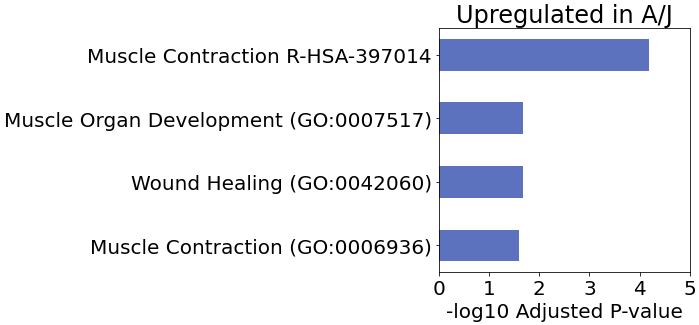

In [198]:
# Plot
plt.figure(figsize=(4.5, 4.5))
plt.barh(df['Term'], df['-log10(Adjusted P-value)'], color='#5C72BF', height = 0.5)
plt.xlabel('-log10 Adjusted P-value', fontsize=20)
plt.ylabel('')
plt.title('Upregulated in A/J', fontsize = 24)
plt.gca().invert_yaxis() 

plt.xticks(np.arange(0, df['-log10(Adjusted P-value)'].max() + 1, 1))
plt.yticks(fontsize=20) 
plt.xticks(fontsize=20)

plt.show()

In [199]:
enr = gp.enrichr(
    gene_list=down['gene_name'].tolist(),
    organism='Mouse', 
    gene_sets=['Reactome_2022', 'GO_Biological_Process_2023']
)
df = enr.results
df = df.sort_values(by="Adjusted P-value", ascending=True)

df['-log10(Adjusted P-value)'] = -np.log10(df['Adjusted P-value'])
df = df[df['Adjusted P-value'] <= 0.05]
df = df.head(4)

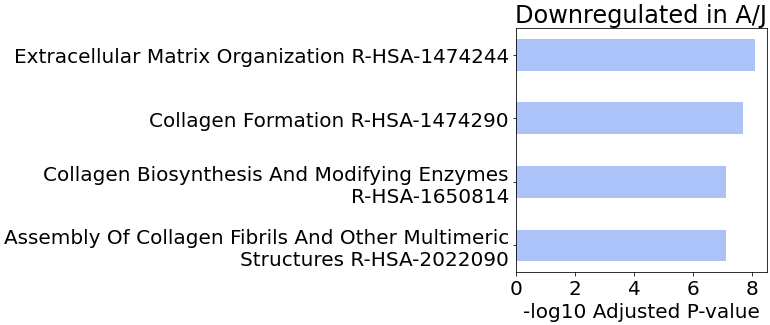

In [200]:
wrapped_labels = [textwrap.fill(label, width=50) for label in df['Term']]

plt.figure(figsize=(4.5, 4.5))
plt.barh(df['Term'], df['-log10(Adjusted P-value)'], color='#ACC3FA', height=0.5)
plt.xlabel('-log10 Adjusted P-value', fontsize=20)
plt.ylabel('')
plt.title('Downregulated in A/J', fontsize=24)
plt.gca().invert_yaxis() 

plt.yticks(ticks=range(len(wrapped_labels)), labels=wrapped_labels, fontsize=20)
plt.xticks(fontsize=20)

plt.show()


# Fig. 5c